OSM Data Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np


In [0]:
"""Utility methods for Exploratory Data Analysis and Pre-processing"""

import os
import shutil
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
#from google.cloud import storage

import seaborn as sns
from sklearn import preprocessing
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import percentileofscore
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

TM_pal_categorical_3 = ("#ef4631", "#10b9ce", "#ff9138")
sns.set(
    style="white",
    font_scale=1,
    palette=TM_pal_categorical_3,
)

SEED = 42
np.random.seed(SEED)

#### Scoring Helper Functions ####
def pearsonr2(estimator, X, y_true):
    """Calculates r-squared score using pearsonr
    
    Parameters
    ----------
    estimator 
        The model or regressor to be evaluated
    X : pandas dataframe or a 2-D matrix
        The feature matrix
    y : list of pandas series
        The target vector
        
    Returns
    ----------
    float
        R2 using pearsonr
    """
    y_pred = estimator.predict(X)
    return pearsonr(y_true, y_pred)[0]**2

def mae(estimator, X, y_true): 
    """Calculates mean absolute error
    
    Parameters
    ----------
    estimator 
        The model or regressor to be evaluated
    X : pandas dataframe or a 2-D matrix
        The feature matrix
    y : list of pandas series
        The target vector
        
    Returns
    ----------
    float
        Mean absolute error
    """
    y_pred = estimator.predict(X)
    return mean_absolute_error(y_true, y_pred)
    
def rmse(estimator, X, y_true): 
    """Calculates root mean squared error
    
    Parameters
    ----------
    estimator 
        The model or regressor to be evaluated
    X : pandas dataframe or a 2-D matrix
        The feature matrix
    y : list of pandas series
        The target vector
        
    Returns
    ----------
    float
        Root mean squared error
    """
    y_pred = estimator.predict(X)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2(estimator, X, y_true): 
    """Calculates r-squared score using python's r2_score function
    
    Parameters
    ----------
    estimator 
        The model or regressor to be evaluated
    X : pandas dataframe or a 2-D matrix
        The feature matrix
    y : list of pandas series
        The target vector
        
    Returns
    ----------
    float
        R-squared score using python's r2_score function
    """
    y_pred = estimator.predict(X)
    return r2_score(y_true, y_pred)  

def mape(estimator, X, y_true): 
    """Calculates mean average percentage error
    
    Parameters
    ----------
    estimator 
        The model or regressor to be evaluated
    X : pandas dataframe or a 2-D matrix
        The feature matrix
    y : list of pandas series
        The target vector
        
    Returns
    ----------
    float
        Mean average percentage error
    """
    y_pred = estimator.predict(X)
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

def adj_r2(estimator, X, y_true):
    """Calculates adjusted r-squared score
    
    Parameters
    ----------
    estimator 
        The model or regressor to be evaluated
    X : pandas dataframe or a 2-D matrix
        The feature matrix
    y : list of pandas series
        The target vector
        
    Returns
    ----------
    float
        Adjusted r-squared score
    """
    y_pred = estimator.predict(X)
    r2 = r2_score(y_true, y_pred)
    n = X.shape[0]
    k = X.shape[1]
    adj_r2 = 1 - (((1-r2)*(n-1))/(n - k - 1))
    
    return adj_r2

def percentile_ranking(series):
    """Converts list of numbers to percentile and ranking
    
    Parameters
    ----------
    series : pandas Series
        A series of numbers to be converted to percentile ranking
    
    Returns
    ----------
    list (of floats)
        A list of converted percentile values using scipy.stats percentileofscore()
    list (of ints)
        A list containing the ranks 
    """
    percentiles = []
    for index, value in series.iteritems():
        curr_index = series.index.isin([index])
        percentile = percentileofscore(series[~curr_index], value)
        percentiles.append(percentile)
    ranks = series.rank(axis=0, ascending=False)
    
    return percentiles, ranks

#### Plotting Helper Functions ####

def plot_hist(data, title, x_label, y_label, bins=30):
    """Plots histogram for the given data
    
    Parameters
    ----------
    data : pandas Series
        The data to plot histogram
    title : str
        The title of the figure
    x_label : str
        Label of the x axis
    y_label : str
        Label of the y-axis
    bins : int
        Number of bins for histogram
    """
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


def plot_regplot(
    data, 
    x_label='Wealth Index', 
    y_label='Average Nightlight Intensity',
    y_var='ntl2016'
):
    """Produces the regression plot for the given data
    
    Parameters
    ----------
    data : pandas Series
        The data to plot regression plot
    x_var : str
        The variable name of the x-axis
    y_var : str
        The variable name of the y-axis
    x_label : str
        Label of the x axis
    y_label : str
        Label of the y-axis
    """
    ax = sns.regplot(
        x=x_label,
        y=y_var,
        data=data,
        lowess=True,
        line_kws={"color": "black", "lw": 2},
        scatter_kws={"alpha": 0.3},
    )
    plt.ticklabel_format(style='sci', axis='x', scilimits=(1,5))
    plt.title(
        "Relationship between {} \nand {}".format(
            x_label, y_label
        )
        + r" ($\rho$ = %.2f, $r$ =%.2f)"
        % (
            spearmanr(
                data[x_label].tolist(), data[y_var].tolist()
            )[0],
            pearsonr(
                data[x_label].tolist(), data[y_var].tolist()
            )[0],
        )
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


def plot_corr(
    data,
    features_cols,
    indicator="Wealth Index",
    figsize=(5, 6),
    max_n=30,
):
    """Produces a barplot of the Spearman rank correlation and Pearson's correlation 
    for a group of values in descending order
    
    Parameters
    ----------
    data : pandas DataFrame
        The dataframe containing the feature columns
    feature_cols : str
        The list of feature column names in the data
    indicator : str (default is "Wealth Index")
        The socioeconomic indicator to correlate each variable with
    figsize : tuple (default is (5,6))
        Size of the figure
    max_n : int
        Maximum number of variables to plot 
    """
    
    n = len(features_cols)
    spearman = []
    pearsons = []
    for feature in features_cols:
        spearman.append(
            (
                feature,
                spearmanr(data[feature], data[indicator])[
                    0
                ],
            )
        )
        pearsons.append(
            (
                feature,
                pearsonr(data[feature], data[indicator])[0],
            )
        )
    spearman = sorted(spearman, key=lambda x: abs(x[1]))
    pearsons = sorted(pearsons, key=lambda x: abs(x[1]))

    plt.figure(figsize=figsize)
    plt.title(
        "Spearman Correlation Coefficient for {}".format(
            indicator
        )
    )
    plt.barh(
        [x[0] for x in spearman[n - max_n :]],
        [x[1] for x in spearman[n - max_n :]],
    )
    plt.grid()

    plt.figure(figsize=figsize)
    plt.title(
        "Pearsons Correlation Coefficient for {}".format(
            indicator
        )
    )
    plt.barh(
        [x[0] for x in pearsons[n - max_n :]],
        [x[1] for x in pearsons[n - max_n :]],
    )
    plt.grid()


#### Nighttime Lights Pre-processing Helper Functions ####

def ntl_agg_fnc(data):
    agg = {}
    agg['mean'] = data['ntl2016'].mean()
    agg['max'] = data['ntl2016'].max()
    agg['min'] = data['ntl2016'].min()
    agg['median'] = data['ntl2016'].median()
    agg['cov'] = data['ntl2016'].cov(data['ntl2016'])
    agg['std'] = data['ntl2016'].std()
    agg['skewness'] =  data['ntl2016'].skew()
    agg['kurtosis'] =  data['ntl2016'].kurtosis()
    return pd.Series(agg, index=[
        'mean', 
        'max', 
        'min', 
        'median', 
        'cov', 
        'std', 
        'skewness', 
        'kurtosis'
    ])

def unstack_clusters(
    data,
    id_col='ID',
    dhs_col='DHSCLUST',
    lat_col='ntllat',
    lon_col='ntllon',
    ntl_col='ntl2016',
    pop_col='pop_sum',
    file_col='filename',
    ph_prefix=True
):
    """ Unstacks nightlights data where certain pixels can belong to two or more clusters. 
    Makes it so that each row is a unique (cluster, id) pair.
    
    Parameters
    ----------
    data : pandas DataFrame
        The nightlights dataset to be unstacked
    
    Returns
    ----------
    pandas DataFrame
        A dataframe of unstacked rows
    """
    
    first_row = data.iloc[0, :]
    temp = {x: [] for x in [id_col, dhs_col, lat_col, lon_col, ntl_col, file_col, pop_col] if x in first_row}
    for index, row in tqdm(
        data.iterrows(), total=len(data)
    ):
        clusters = [
            x.strip() for x in row[dhs_col].split(",")
        ]
        for cluster in clusters:
            if ph_prefix:
                cluster = cluster.replace("PH2017", "").lstrip("0")
            temp[dhs_col].append(int(cluster))
            if id_col in row:
                temp[id_col].append(row[id_col])
            if lon_col in row:
                temp[lon_col].append(row[lon_col])
            if lat_col in row:
                temp[lat_col].append(row[lat_col])
            if ntl_col in row:
                temp[ntl_col].append(row[ntl_col])
            if pop_col in row:
                temp[pop_col].append(row[pop_col])
            if file_col in row:
                temp[file_col].append(row[file_col])
    data = pd.DataFrame(temp)
    
    return data


def gaussian_mixture_model(
    data, 
    ntl_col='ntl2016',
    n_components=3, 
    max_iter=1000,
    tol=1e-10,
    covariance_type='full',
    bin_labels=['low', 'medium', 'high']
):
    """ Implements Gaussian Mixture Model (GMM) on the nighttime light intensities
    
    Parameters
    ----------
    data : pandas DataFrame
        Contains the nightlights column to be binned 
    ntl_col : str
        Name of the column containing nightlight intensities
    n_components : int (default is 3)
        Number of components for the GMM
    max_iter : int (default is 1000)
        Maximum number of iterations for GMM
    tol : float (default is 1e-10)
        GMM tolerance
    covariance_type: str (default is 'full')
        GMM covariance type
        
    Returns
    ----------
    pandas DataFrame
        A dataframe containing an additional field 'label' indicating the nightlight intensity level
    """
    series = np.array(data[ntl_col]).reshape(-1, 1)

    # Instantiate GMM
    gmm = GaussianMixture(
        n_components=n_components,
        max_iter=max_iter,
        tol=tol,
        covariance_type=covariance_type,
        random_state=SEED,
    ).fit(series)

    # Predict
    intensities = gmm.predict(series)

    # Assign night light intensity levels
    data["label"] = intensities
    
    bin_caps = {}
    for x in range(n_components):
        bin_caps[x] = data[data['label'] == x][ntl_col].max()
    print(bin_caps)
    bin_caps = sorted(bin_caps.items(), key=operator.itemgetter(1))
    
    assign_labels = {}
    for val, label in zip(bin_caps, bin_labels):
        assign_labels[val[0]] = label
    print(assign_labels)
    
    data["label"] = data["label"].replace(
        assign_labels
    )
    
    return data


def ad_hoc_binning(
    intensity, 
    bin_caps=[2, 20],
    bin_labels=['low', 'medium', 'high']
):
    """Implements ad-hoc binning (3 bins) for nighttime lights
    
    Parameters
    ----------
    intensity : float
        The nighttime light intensity of a single pixel
    bin_caps : list
        Maximum values per bin (should contain n-1 bins as there is 
        no need to specify the maximum cap of the last bin)
    
    Returns
    ----------
    str
        Indicates nighttime light intensity (low, medium, or high)
    """
    bin_caps.append(1e100)
    for val, label in zip(bin_caps, bin_labels):
        if intensity <= val:
            return label


def train_val_split(data, train_size=0.9):
    """Splits the data into training and validation set. 
    
    Parameters
    ----------
    data : pandas DataFrame
        The data to be split
    train_size : float (default is 0.9)
        The size of the training set. Size of validation set is 1 - train_size
        
    Returns
    -------
    pandas DataFrame
        The training set
    pandas DataFrame
        The validation set
    """
    
    train = data.iloc[: int(len(data) * train_size), :]
    val = data.iloc[int(len(data) * train_size) :, :]
    
    return train, val

def balance_dataset(data, size=60000):
    """Implements upsampling and downsampling for the three classes (low, medium, and high)
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the labels indicating the different nightlight intensity bins
    size : int
        The number of samples per classes for upsampling and downsampling
    
    Returns
    -------
    pandas DataFrame
        The data with relabelled and balanced nightlight intensity classes
    """
    
    bin_labels = data.label.unique()
    
    classes = []
    for label in bin_labels:
        class_ = data[data.label == label].reset_index()
        if len(class_) >= size:
            sample = class_.sample(
                n=size, replace=False, random_state=SEED
            )
        elif len(class_) < size:
            sample = class_.sample(
                n=size, replace=True, random_state=SEED
            )
        classes.append(sample)

    data_balanced = pd.concat(classes)
    data_balanced = data_balanced.sample(
        frac=1, random_state=SEED
    ).reset_index(drop=True)
    data_balanced = data_balanced.iloc[:, 1:]
    return data_balanced


def train_val_split_images(data, report, dst_dir, phase="train"):
    """Splits the downloaded images into training and validation folders
        
    Parameters
    ----------
    data : pandas DataFrame
        Contains the class labels of each image, idetified by its lat lng
    report : pandas DataFrame
        Contains the file locations of each images based on the lat lngs
    phase : str
        Indicates whether training or validation set
    """
    
    for index, row in tqdm(
        data.iterrows(), total=len(data)
    ):
        label = row["label"]
        lat = row["ntllat"]
        lon = row["ntllon"]
        id_ = row["ID"]

        image = report[
            (report["lat"] == lat)
            & (report["lon"] == lon)
            & (report["id"] == id_)
        ]
        if len(image) != 0:
            src_dir = image["filename"].iloc[0]
            filename = os.path.basename(src_dir)
            filename = filename.split(".")
            dst_file = "{}{}/{}".format(dst_dir, phase, label)
            dst_file = "{}/{}_{}.{}".format(
                dst_file, 
                ".".join(x for x in filename[:-1]), 
                str(index),
                filename[-1]
            )
            os.makedirs(
                os.path.dirname(dst_file), exist_ok=True
            )
            shutil.copyfile(src_dir, dst_file)


#### Gooogle Cloud Storage Migration Helper Functions ####

def upload_to_bucket(
    blob_name, directory, path_to_file, bucket_name
):
    """ Upload data to a Google Cloud Storage bucket
    
    Parameters
    ----------
    blob_name : str
        Name of file in GCS once uploaded
    directory : str
        GCS directory
    path_to_file : str
        Local path to file
    bucket_name : str
        Name of GCS bucket
    
    Returns
    -------
    str
        The public url of the file
    """

    storage_client = storage.Client()
    buckets = list(storage_client.list_buckets())
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob("{}/{}".format(directory, blob_name))
    blob.upload_from_filename(path_to_file)

    print("{} successfully uploaded".format(path_to_file))
    return blob.public_url


def download_from_bucket(
    blob_name, directory, destination_file_name, bucket_name
):
    """ Download data from Gogle Cloud Storage bucket
    
    Parameters
    ----------
    blob_name : str
        Name of file in GCS once uploaded
    directory : str
        GCS directory
    path_to_file : str
        Local path to file
    bucket_name : str
        Name of GCS bucket
    
    Returns
    -------
    str
        The public url of the file
    """
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob("{}/{}".format(directory, blob_name))

    destination_file_dir = os.path.dirname(
        destination_file_name
    )
    if not os.path.exists(destination_file_dir):
        os.makedirs(destination_file_dir)
    blob.download_to_filename(destination_file_name)

    print(
        "{} successfully downloaded".format(
            destination_file_name
        )
    )
    return blob.public_url

In [0]:
"""Utility methods for evaluating Wealth Prediction Models"""

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
from scipy import stats
from math import sqrt

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict,
)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    make_scorer,
    roc_auc_score,
    balanced_accuracy_score,
)
from sklearn.svm import SVR, SVC
import seaborn as sns

TM_pal_categorical_3 = ("#ef4631", "#10b9ce", "#ff9138")
sns.set(
    style="white",
    font_scale=1.25,
    palette=TM_pal_categorical_3,
)

SEED = 42
np.random.seed(SEED)

def evaluate_model(
    data,
    feature_cols,
    indicator_cols,
    model_type="ridge",
    scoring={"r2": "r2"},
    refit="r2",
    search_type="random",
    n_splits=5,
    n_iter=50,
    task_type="regression",
    plot_importance=False,
    figsize=(5, 8),
    std_scale=False,
    minmax_scale=False,
    polynomial=False,
    poly_degree=2,
    n_workers=-1,
    verbose=0,
    plot=True
):
    """ Automatically trains and evaluates the specified model on given dataset 
    using an n-fold nested cross validation scheme. Supported models so far are:
    ridge regression, random forest regression, and xgboost regression.
    
    Parameters
    ----------
    data : pandas DataFrame
        A pandas dataframe containing the feature and indicator columns
    feature_cols : list
        The list of predictive features to be used for training
    indicator_cols : list
        The list of socioeconomic indicators to be predicted
    model_type : str (default is 'ridge')
        Type of model to use. Supported types so far are: 'ridge', 'random_forest', and 'xgboost'
    scoring : dict (default is {"r2": "r2"})
        A dictionary containing the scoring metrics to be used 
    refit : str (default is 'r2')
        Scoring metric to be optimized
    search_type : str (default is random)
        Search type: either 'grid' or 'random'
    n_splits : int (default is 5)
        Number of splits/folds for the n-fold cross validation
    n_iter : int (default is 50)
        Number of iterations for the random search cross validation
    task_type : str (default is 'regression')
        The type of task: either 'classification' or 'regression'
    plot_importance : bool (default is False)
        Indicates whether or not to plot feature importance. Applicable to random forest or xgboost only.
    figsize : tuple (default is (5,8))
        Size of feature importance plot
    std_scale : bool (default is False)
        Indicates whether or not to apply standard scaling to features
    minmax_scale : bool (default is False)
        Indicates whether or not to apply min-max scaling to features
    
    Returns
    ----------
    pandas DataFrame 
        Contains cluster number, actual, and predicted socioeconomic indicators
    """
    clust_str = "Cluster number"

    # Set up parameter grid
    param_grid = get_param_grid(model_type)
        
    # Initialize results dictionary
    results = {
        indicator + type_: []
        for indicator in indicator_cols
        for type_ in ["_pred", "_true"]
    }

    # Iterate over the socioeconomic indicators
    for index, indicator in enumerate(indicator_cols):        
        X = data[feature_cols]
        y = data[indicator].tolist()
        clusters = data[clust_str].tolist()

        # Instantiate model
        model = get_model(model_type)
            
        # Nested cross validation
        cv, nested_scores, y_true, y_pred = nested_cross_validation(
            model,
            X,
            y,
            param_grid=param_grid,
            scoring=scoring,
            refit=refit,
            search_type=search_type,
            n_splits=n_splits,
            n_iter=n_iter,
            task_type=task_type,
            std_scale=std_scale,
            minmax_scale=minmax_scale,
            polynomial=polynomial,
            poly_degree=poly_degree,
            n_workers=n_workers,
            verbose=verbose,
        )

        # Display scores
        print(
            "Socioeconomic indicator: {}".format(indicator)
        )
        for score in nested_scores:
            print(
                score,
                ": %.4f" % nested_scores[score].mean(),
            )
            print(nested_scores[score])
            if score == 'test_r2':
                r_squared = nested_scores[score].mean()
        
        formatted_indicator = ' '.join([x for x in indicator.split() if '(' not in x]).title()
        if wandb is not None:
            wandb.log({'{} R-squared'.format(formatted_indicator): r_squared})
        
        # Plot results
        if plot:
            plot_cross_val_results(
                y_true,
                y_pred,
                formatted_indicator,
                nested_scores,
                wandb=wandb,
                refit=refit
            )
        
        # Get best estimator
        cv.fit(X, y)
        print(
            "Best estimator: {}".format(cv.best_estimator_)
        )

        # Save results
        results[indicator + "_pred"] = y_pred
        results[indicator + "_true"] = y_true
        results[clust_str] = clusters

        # Plot feature importances (for tree-based models only)
        if plot_importance:
            if model_type == "random_forest":
                rf_feature_importance(
                    cv, X, y, size=figsize
                )
            elif model_type == "xgboost":
                xgb_feature_importance(
                    cv, X, y, size=figsize
                )
                
    return pd.DataFrame(results)

def get_param_grid(model_type='ridge'):
    """Returns the model parameter grid to be used as input for cross validation 
    hyper parameter optimization
    
    Parameters
    ----------
    model_type : str (default is 'ridge')
        Type of model to use. Supported types so far are: 'ridge', 'random_forest', 
        and 'xgboost'
    
    Returns
    ----------
    dict
        A dictionary of parameters 
    """
    np.random.seed(SEED)
    if (model_type == "ridge") or (model_type == "lasso"):
        param_grid = {
            "regressor__alpha": stats.uniform.rvs(loc=0, scale=4, size=3),
            "regressor__normalize": [True, False],
        }
    if model_type == "elastic_net":
        param_grid = {
            "regressor__alpha": stats.uniform.rvs(loc=0, scale=4, size=3),
            "regressor__l1_ratio": np.random.uniform(0, 1, 10),
            "regressor__normalize": [True, False],
        }
    elif model_type == "random_forest":
        param_grid = {
            "regressor__n_estimators": stats.randint(200, 2000),
            "regressor__max_features": ["auto", "sqrt", "log2"],
            "regressor__max_depth": stats.randint(3, 10),
            "regressor__min_samples_split": stats.randint(2, 10),
            "regressor__min_samples_leaf": stats.randint(1, 10),
            "regressor__bootstrap": [True, False],
        }
    elif model_type == "xgboost":
        param_grid = {
            "regressor__n_estimators": stats.randint(200, 2000),
            "regressor__learning_rate": np.random.uniform(1e-3, 0.2, 100),
            "regressor__subsample": np.random.uniform(0.9, 1, 100),
            "regressor__max_depth": stats.randint(3, 10),
            "regressor__colsample_bytree": np.random.uniform(0.7, 1, 100),
            "regressor__min_child_weight": stats.randint(1, 5),
            "regressor__gamma": np.random.uniform(0.5, 5, 100),
        }
    elif model_type == "svr":
        param_grid = {
            "regressor__kernel": ["linear", "poly", "rbf"],
            "regressor__degree": stats.randint(1, 5),
            "regressor__gamma": ["auto", "scale"],
            "regressor__C": np.random.uniform(0, 10, 100),
        }
    return param_grid

def get_model(model_type='ridge'):
    """Returns the model instance to be used as input for cross validation 
    
    Parameters
    ----------
    model_type : str (default is 'ridge')
        Type of model to use. Supported types so far are: 'ridge', 'random_forest', 
        and 'xgboost'
    
    Returns
    ----------
    model instance
        Model to be evaluated
    """
    np.random.seed(SEED)
    if model_type == "ridge":
        model = Ridge(random_state=SEED)
    elif model_type == "lasso":
        model = Lasso(random_state=SEED)
    elif model_type == "elastic_net":
        model = ElasticNet(random_state=SEED)
    elif model_type == "random_forest":
        model = RandomForestRegressor(
            random_state=SEED, 
            n_jobs=-1
        )
    elif model_type == "xgboost":
        model = xgb.XGBRegressor(
            objective="reg:linear",
            random_state=SEED,
            n_jobs=-1,
        )
    elif model_type == "svr":
        model = SVR()
        
    return model

def nested_cross_validation(
    model,
    X,
    y,
    param_grid,
    scoring,
    refit,
    search_type="random",
    n_splits=5,
    n_iter=50,
    std_scale=False,
    minmax_scale=False,
    polynomial=False,
    poly_degree=2,
    task_type="regression",
    n_workers=-1,
    verbose=0
):
    """An implementation of n-fold nested cross validation.
    
    Parameters
    ----------
    model: 
        The model to be used for cross validation
    X : pandas DataFrame, numpy array, or 2D list
        Contains the feature matrix for training
    y : pandas Series or list
        Contains the target vector to predict
    param_grid : dict
        Contains the dictionary of parameters to be optimized.
        Keys are the parameter names, values contain the range of values for that parameter.
    scoring : dict (default is {"r2": "r2"})
        A dictionary containing the scoring metrics to be used 
    refit : str (default is 'r2')
        Scoring metric to be optimized
    search_type : str (default is random)
        Search type: either 'grid' or 'random'
    n_splits : int (default is 5)
        Number of splits/folds for the n-fold cross validation
    n_iter : int (default is 30)
        Number of iterations for the random search cross validation
    task_type : str (default is 'regression')
        The type of task: either 'classification' or 'regression'
    std_scale : bool (default is False)
        Indicates whether or not to apply standard scaling to features
    minmax_scale : bool (default is False)
        Indicates whether or not to apply min-max scaling to features
        
    Returns 
    ----------
    CV instance
        Either an instance of GridSearchCV or RandomSearchCV
    dict
        A dictionary containing the scores specified in the scoring dictionary
    """
    np.random.seed(SEED)
    
    # Define inner and outer cross validation folds
    if task_type == "classification":
        inner_cv = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED,
        )
        outer_cv = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED,
        )
    elif task_type == "regression":
        inner_cv = KFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED,
        )
        outer_cv = KFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED,
        )
        
    # Define pipeline: transformation + models
    pipeline = []
    if std_scale:
        std_scaler = StandardScaler()
        pipeline.append(("std_scale", std_scaler))
    if minmax_scale:
        minmax_scaler = MinMaxScaler()
        pipeline.append(("minmax_scale", minmax_scaler))
    if polynomial:
        poly = PolynomialFeatures(degree=poly_degree)
        pipeline.append(("poly", poly))
    if task_type == "regression":
        pipeline.append(("regressor", model))
    pipe = Pipeline(pipeline)

    # Define search type: grid or random
    if search_type == "grid":
        cv = GridSearchCV(
            estimator=pipe,
            scoring=scoring,
            param_grid=param_grid,
            cv=inner_cv,
            verbose=verbose,
            n_jobs=n_workers,
            refit=refit,
        )
    elif search_type == "random":
        cv = RandomizedSearchCV(
            estimator=pipe,
            n_iter=n_iter,
            scoring=scoring,
            param_distributions=param_grid,
            cv=inner_cv,
            verbose=verbose,
            random_state=SEED,
            n_jobs=n_workers,
            refit=refit,
        )
        
    # Commence cross validation
    nested_scores = cross_validate(
        cv,
        X=X,
        y=y,
        cv=outer_cv,
        n_jobs=n_workers,
        scoring=scoring,
        verbose=verbose,
        return_train_score=True,
    )
    
    # Get cross validated predictions
    y_pred = cross_val_predict(
        cv, 
        X=X, 
        y=y, 
        cv=outer_cv,
        n_jobs=n_workers,
        verbose=verbose
    )        
    
    return cv, nested_scores, y, y_pred

def plot_cross_val_results(
    y_true,
    y_pred,
    indicator,
    nested_scores,
    wandb,
    refit='r2'
):
    """Plots cross validated estimates.
    
    Parameters
    ----------
    y_true : pandas Series or list
        Contains the ground-truth target vector 
    y_pred : pandas Series or list
        Contains the predictions
    indicator : str
        A string value specifying the indicator
    nested_scores : dict
        A dictionary of output scores produced through cross validation
    refit : str (default is 'r2')
        Scoring metric to be optimized
    """
    
    # Get cross validation results
    #y_pred = cross_val_predict(cv_model, X, y, cv=n_splits)

    # Plot Actual vs Predicted
    ax = sns.regplot(
        y_true,
        y_pred,
        line_kws={"color": "black", "lw": 1},
        scatter_kws={"alpha": 0.3},
    )
    plt.title(
        indicator
        + r" $r^2: {0:.3f}$".format(
            nested_scores["test_" + str(refit)].mean()
        )
    )
    plt.xlabel("Observed " + indicator.lower())
    plt.ylabel("Predicted " + indicator.lower())
    if wandb is not None:
        wandb.log({'{}'.format(indicator): wandb.Image(plt)})
    plt.show()

def rf_feature_importance(
    cv, X, y, n_features=30, size=(10, 15)
):
    """ Plots the feature importances for random forest regressor.
    
    Parameters
    ----------
    cv :         
    X : pandas DataFrame, numpy array, or 2D list
        Contains the feature matrix for training
    y : pandas Series or list
        Contains the target vector to predict
    n_features : int
        Number of features to plot
    size : tuple
        Size of the figure
    """

    feat_impt = {}
    for z in range(len(X.columns)):
        feat_impt[
            X.columns[z]
        ] = cv.best_estimator_.named_steps[
            "regressor"
        ].feature_importances_[
            z
        ]
    pd.DataFrame(
        {"Feature Importance": feat_impt}
    ).sort_values(
        by="Feature Importance", ascending=False
    ).iloc[
        :n_features
    ].plot(
        kind="barh", figsize=size
    )
    plt.grid()
    plt.gca().invert_yaxis()
    plt.show()


def xgb_feature_importance(
    cv, X, y, n_features=30, size=(10, 15)
):
    """ Plots the feature importances for XGBoost regressor.
    
    Parameters
    ----------
    cv :         
    X : pandas DataFrame, numpy array, or 2D list
        Contains the feature matrix for training
    y : pandas Series or list
        Contains the target vector to predict
    n_features : int
        Number of features to plot
    size : tuple
        Size of the figure
    """

    fig, ax = plt.subplots(1, 1, figsize=size)
    xgb.plot_importance(
        cv.best_estimator_.named_steps["regressor"], ax=ax
    )
    plt.show()

## File Location

In [0]:
#bucket_name = 'tm-geospatial'
#directory = 'poverty-prediction-datasets'

#data_dir = '../data/zoom17/'
ntl_summary_stats_file = '/content/drive/My Drive/Thesis/DHS_nightlights.csv'
dhs_indicators_file = '/content/drive/My Drive/Thesis/DHS_Data/bangladesh_cluster_avg_asset_2013_updated_new.csv'

osm_roads_file = '/content/drive/My Drive/Thesis/OSM_data/clusters_road_model.csv'
osm_landuse_file = '/content/drive/My Drive/Thesis/OSM_data/clusters_landuse_model.csv'
osm_pois_file = '/content/drive/My Drive/Thesis/OSM_data/clusters_pois_model.csv'

### Load Dataset

In [0]:
# Load DHS indicators and nighttime lights
dhs_indicators = pd.read_csv(dhs_indicators_file)
ntl_summary_stats = pd.read_csv(ntl_summary_stats_file)

# Load OSM datasets
roads = pd.read_csv(osm_roads_file)
landuse = pd.read_csv(osm_landuse_file)
pois = pd.read_csv(osm_pois_file)

# Define feature columns
road_cols = roads.columns[1:]
landuse_cols = landuse.columns[1:]
poi_cols = pois.columns[1:]
ntl_cols = ntl_summary_stats.columns[:-1]

# Get list of columns
osm_cols = list(road_cols) + list(landuse_cols) + list(poi_cols)
osm_ntl_cols = list(osm_cols) + list(ntl_cols)

In [0]:
#Drop cluster without location info
#ntl_summary_stats = ntl_summary_stats.drop([543], axis = 0)

### Combine Features

In [39]:
# Merge roads + buildings + pois
osm = roads.merge(landuse, on='cluster')
osm = osm.merge(pois, on='cluster')
print("Shape of osm dataframe: {}".format(osm.shape))

# Merge osm + nightlights
osm_ntl = osm.merge(ntl_summary_stats, left_on='cluster', right_on = 'id')
print("Shape of osm+ntl dataframe: {}".format(osm_ntl.shape))

# merge dhs + osm
dhs = dhs_indicators.merge(osm_ntl, left_on='cluster', right_on='cluster')

Shape of osm dataframe: (599, 220)
Shape of osm+ntl dataframe: (599, 227)


### Spearman and Pearsons Correlation¶


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning

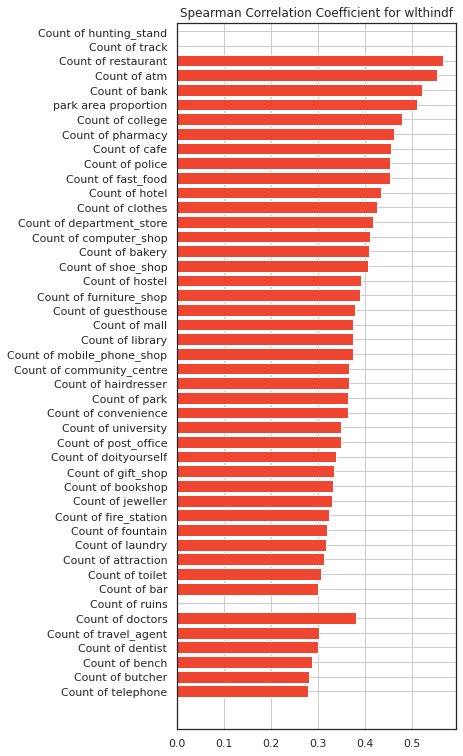

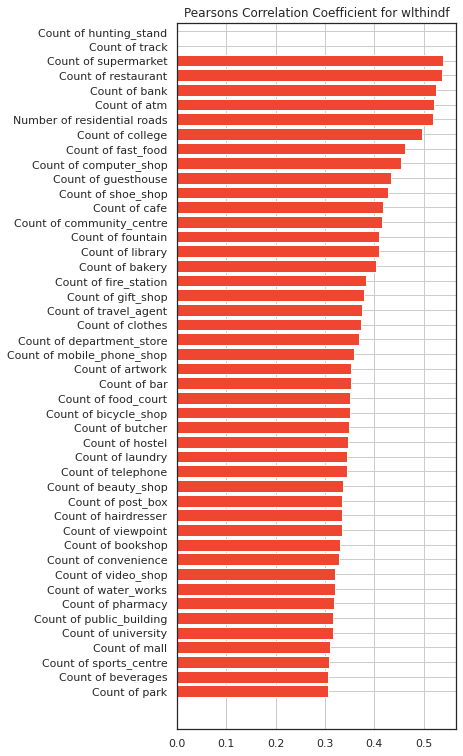

In [13]:
plot_corr(
    data=dhs,
    features_cols=osm_cols,
    indicator = 'wlthindf',
    max_n=50,
    figsize=(5,13)
);

### Machine Learning Pipeline

#### Configuration

In [0]:
# Scoring metrics
scoring = {
    'r2': pearsonr2,
    'rmse': rmse
}

# Indicators of interest
indicators = [
    'wlthindf'
]

In [42]:
#osm_ntl = osm_ntl.drop(osm_ntl.columns[[-7, 0]], axis=1)
osm_ntl = osm_ntl.drop(osm_ntl.columns[[0]], axis=1)
osm_ntl

,Distance to nearest intersection road,Distance to nearest living_street road,Distance to nearest pedestrian road,Distance to nearest primary road,Distance to nearest residential road,Distance to nearest secondary road,Distance to nearest service road,Distance to nearest tertiary road,Distance to nearest track road,Distance to nearest trunk road,Length of all road,Length of intersection road,Length of living_street road,Length of pedestrian road,Length of primary road,Length of residential road,Length of secondary road,Length of service road,Length of tertiary road,Length of track road,Length of trunk road,Number of intersection roads,Number of living street roads,Number of pedestrian roads,Number of primary roads,Number of residential roads,Number of secondary roads,Number of service roads,Number of tertiary roads,Number of track roads,Number of trunk roads,Total number of roads,Unnamed: 0_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,...,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross,max_,min_,mean_,median_,std_,wealth
0,60928.184920,9700.353722,6533.345722,346.880648,0.0,6333.662907,7288.626275,0.000000,0.00000,51030.96147,74906.33711,0.000000,0.000000,0.0,0.000000,889.964217,0.000000,0.000000,10641.699610,6252.403740,0.000000,0,0,0,0,1,0,0,1,11,0,46,0,1.277760,1.776912e-05,1.629511e-08,0.000000,0.000000,0.000000e+00,0.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.831240
1,38054.358910,0.000000,36909.723550,0.000000,0.0,346.618103,41.580314,0.000000,0.00000,19255.33551,293445.93460,0.000000,1194.175248,0.0,5326.164337,113223.639400,0.000000,0.000000,19296.179320,1741.874709,0.000000,0,3,0,0,212,0,0,13,7,0,413,1,0.068292,9.497009e-07,8.709197e-10,0.000000,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.739180
2,42746.453730,0.000000,22777.557160,0.000000,0.0,0.000000,0.000000,137.218833,0.00000,25734.76509,164727.44710,0.000000,272.771862,0.0,5218.491856,79178.660280,6158.149800,153.354248,0.000000,1555.077419,0.000000,0,1,0,0,140,2,3,0,12,0,269,2,20.866257,2.901759e-04,2.661047e-07,0.000000,0.000000,0.000000e+00,0.095643,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.786210
3,40856.505970,0.000000,18674.706230,0.000000,0.0,2974.080532,0.000000,0.000000,0.00000,28817.87451,285357.76710,0.000000,2474.866835,0.0,9373.134867,130028.318400,0.000000,11.798247,2693.772358,784.603224,0.000000,0,11,0,0,235,0,0,3,10,0,486,3,14.808510,2.059340e-04,1.888510e-07,0.000000,0.000000,0.000000e+00,0.095643,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,0.0,1.31,0.0,3.148635,-0.447090
4,28534.582590,4138.571558,14766.536740,0.000000,0.0,7970.633521,3948.732288,3608.120773,6169.56508,20634.76748,21559.80854,0.000000,0.000000,0.0,7963.099905,2169.925315,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,4,4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.687435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

#### OSM + Nightlight Features

In [44]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = osm_ntl
data_all = data_all.as_matrix()
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


R^2 of the best model: 0.6075445878613961


In [66]:
osm_ntl

,Distance to nearest intersection road,Distance to nearest living_street road,Distance to nearest pedestrian road,Distance to nearest primary road,Distance to nearest residential road,Distance to nearest secondary road,Distance to nearest service road,Distance to nearest tertiary road,Distance to nearest track road,Distance to nearest trunk road,Length of all road,Length of intersection road,Length of living_street road,Length of pedestrian road,Length of primary road,Length of residential road,Length of secondary road,Length of service road,Length of tertiary road,Length of track road,Length of trunk road,Number of intersection roads,Number of living street roads,Number of pedestrian roads,Number of primary roads,Number of residential roads,Number of secondary roads,Number of service roads,Number of tertiary roads,Number of track roads,Number of trunk roads,Total number of roads,Unnamed: 0_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,...,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross,max_,min_,mean_,median_,std_,wealth
0,60928.184920,9700.353722,6533.345722,346.880648,0.0,6333.662907,7288.626275,0.000000,0.00000,51030.96147,74906.33711,0.000000,0.000000,0.0,0.000000,889.964217,0.000000,0.000000,10641.699610,6252.403740,0.000000,0,0,0,0,1,0,0,1,11,0,46,0,1.277760,1.776912e-05,1.629511e-08,0.000000,0.000000,0.000000e+00,0.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.831240
1,38054.358910,0.000000,36909.723550,0.000000,0.0,346.618103,41.580314,0.000000,0.00000,19255.33551,293445.93460,0.000000,1194.175248,0.0,5326.164337,113223.639400,0.000000,0.000000,19296.179320,1741.874709,0.000000,0,3,0,0,212,0,0,13,7,0,413,1,0.068292,9.497009e-07,8.709197e-10,0.000000,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.739180
2,42746.453730,0.000000,22777.557160,0.000000,0.0,0.000000,0.000000,137.218833,0.00000,25734.76509,164727.44710,0.000000,272.771862,0.0,5218.491856,79178.660280,6158.149800,153.354248,0.000000,1555.077419,0.000000,0,1,0,0,140,2,3,0,12,0,269,2,20.866257,2.901759e-04,2.661047e-07,0.000000,0.000000,0.000000e+00,0.095643,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.786210
3,40856.505970,0.000000,18674.706230,0.000000,0.0,2974.080532,0.000000,0.000000,0.00000,28817.87451,285357.76710,0.000000,2474.866835,0.0,9373.134867,130028.318400,0.000000,11.798247,2693.772358,784.603224,0.000000,0,11,0,0,235,0,0,3,10,0,486,3,14.808510,2.059340e-04,1.888510e-07,0.000000,0.000000,0.000000e+00,0.095643,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,0.0,1.31,0.0,3.148635,-0.447090
4,28534.582590,4138.571558,14766.536740,0.000000,0.0,7970.633521,3948.732288,3608.120773,6169.56508,20634.76748,21559.80854,0.000000,0.000000,0.0,7963.099905,2169.925315,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,4,4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.687435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [60]:
osm_ntl

,Distance to nearest intersection road,Distance to nearest living_street road,Distance to nearest pedestrian road,Distance to nearest primary road,Distance to nearest residential road,Distance to nearest secondary road,Distance to nearest service road,Distance to nearest tertiary road,Distance to nearest track road,Distance to nearest trunk road,Length of all road,Length of intersection road,Length of living_street road,Length of pedestrian road,Length of primary road,Length of residential road,Length of secondary road,Length of service road,Length of tertiary road,Length of track road,Length of trunk road,Number of intersection roads,Number of living street roads,Number of pedestrian roads,Number of primary roads,Number of residential roads,Number of secondary roads,Number of service roads,Number of tertiary roads,Number of track roads,Number of trunk roads,Total number of roads,Unnamed: 0_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,forest area total,...,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross,max_,min_,mean_,median_,std_,wealth
0,60928.184920,9700.353722,6533.345722,346.880648,0.0,6333.662907,7288.626275,0.000000,0.00000,51030.96147,74906.33711,0.000000,0.000000,0.0,0.000000,889.964217,0.000000,0.000000,10641.699610,6252.403740,0.000000,0,0,0,0,1,0,0,1,11,0,46,0,1.277760,1.776912e-05,1.629511e-08,0.000000,0.000000,0.000000e+00,0.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.831240
1,38054.358910,0.000000,36909.723550,0.000000,0.0,346.618103,41.580314,0.000000,0.00000,19255.33551,293445.93460,0.000000,1194.175248,0.0,5326.164337,113223.639400,0.000000,0.000000,19296.179320,1741.874709,0.000000,0,3,0,0,212,0,0,13,7,0,413,1,0.068292,9.497009e-07,8.709197e-10,0.000000,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.739180
2,42746.453730,0.000000,22777.557160,0.000000,0.0,0.000000,0.000000,137.218833,0.00000,25734.76509,164727.44710,0.000000,272.771862,0.0,5218.491856,79178.660280,6158.149800,153.354248,0.000000,1555.077419,0.000000,0,1,0,0,140,2,3,0,12,0,269,2,20.866257,2.901759e-04,2.661047e-07,0.000000,0.000000,0.000000e+00,0.095643,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.786210
3,40856.505970,0.000000,18674.706230,0.000000,0.0,2974.080532,0.000000,0.000000,0.00000,28817.87451,285357.76710,0.000000,2474.866835,0.0,9373.134867,130028.318400,0.000000,11.798247,2693.772358,784.603224,0.000000,0,11,0,0,235,0,0,3,10,0,486,3,14.808510,2.059340e-04,1.888510e-07,0.000000,0.000000,0.000000e+00,0.095643,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,0.0,1.31,0.0,3.148635,-0.447090
4,28534.582590,4138.571558,14766.536740,0.000000,0.0,7970.633521,3948.732288,3608.120773,6169.56508,20634.76748,21559.80854,0.000000,0.000000,0.0,7963.099905,2169.925315,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,4,4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,0.0,0.000000,-0.687435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [45]:
from sklearn.linear_model import Lasso

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Lasso(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4917763261672832, tolerance: 0.039925094181926545
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.127954607596095, tolerance: 0.03884549265980519
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9661833260019108, tolerance: 0.038128731141901004
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.

R^2 of the best model: 0.6010791798002515


In [46]:
from sklearn.linear_model import ElasticNet

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = ElasticNet(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.382459347148512, tolerance: 0.0395563110897657
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20527107858163163, tolerance: 0.03820885587259597
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.325528524453105, tolerance: 0.038325631691624465
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3

R^2 of the best model: 0.5991655933462703


In [47]:
from sklearn.ensemble import RandomForestRegressor

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = RandomForestRegressor()
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.6216812357435249


In [0]:
class Metrics(object):
  """Performance metrics for regressor."""

  def __init__(self, y_true, predictions):
    self.y_true = y_true
    self.predictions = predictions
    self.residuals = self.y_true - self.predictions
    self.rmse = self.calculate_rmse(self.residuals)
    self.mae = self.calculate_mae(self.residuals)
    self.malr = self.calculate_malr(self.y_true, self.predictions)

  def calculate_rmse(self, residuals):
    """Root mean squared error."""
    return np.sqrt(np.mean(np.square(residuals)))

  def calculate_mae(self, residuals):
    """Mean absolute error."""
    return np.mean(np.abs(residuals))

  def calculate_malr(self, y_true, predictions):
    """Mean absolute log ratio."""
    return np.mean(np.abs(np.log(1 + predictions) - np.log(1 + y_true)))

  def report(self, name=None):
    if name is not None:
      print_string = '{} results'.format(name)
      print(print_string)
      print('~' * len(print_string))
    print('RMSE: {:2.3f}\nMAE: {:2.3f}\nMALR: {:2.3f}'.format(
        self.rmse, self.mae, self.malr))


In [82]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


data_all = osm_ntl
data_all = data_all.as_matrix()


kf = KFold(n_splits=10, shuffle=True)
scores = []
for train_index, test_index in kf.split(data_all):
  train = data_all[train_index]
  test = data_all[test_index]
  xgb = XGBRegressor()
  xgb.fit(train[:, :-1], train[:, -1])
  xgb_pred = xgb.predict(test[:, :-1])
  XGBoost_metrics = Metrics(test[:, -1], xgb_pred)
#  XGBoost_metrics.report("XGBoost")

# Look at the R^2 scores on train and test
print("R2 train: ", xgb.score(train[:, :-1], train[:, -1]))
print("R2 test: ", xgb.score(test[:, :-1], test[:, -1]))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[19:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


[19:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Just OSM Data

In [65]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = dhs
data_all = data_all.as_matrix()
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, 1:], train[:, 0])
        s = reg.score(test[:, 1:], test[:, 0])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


R^2 of the best model: 0.6075440180397624


In [64]:
#dhs = dhs.drop(dhs.columns[[0, 1, 3, 4, 5, 6]], axis=1)
dhs = dhs.drop(dhs.columns[[-1]], axis=1)
dhs

,wlthindf,Distance to nearest intersection road,Distance to nearest living_street road,Distance to nearest pedestrian road,Distance to nearest primary road,Distance to nearest residential road,Distance to nearest secondary road,Distance to nearest service road,Distance to nearest tertiary road,Distance to nearest track road,Distance to nearest trunk road,Length of all road,Length of intersection road,Length of living_street road,Length of pedestrian road,Length of primary road,Length of residential road,Length of secondary road,Length of service road,Length of tertiary road,Length of track road,Length of trunk road,Number of intersection roads,Number of living street roads,Number of pedestrian roads,Number of primary roads,Number of residential roads,Number of secondary roads,Number of service roads,Number of tertiary roads,Number of track roads,Number of trunk roads,Total number of roads,Unnamed: 0_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,...,Count of shelter,Count of beauty_shop,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross,id,max_,min_,mean_,median_,std_
0,-0.831240,60928.184920,9700.353722,6533.345722,346.880648,0.0,6333.662907,7288.626275,0.000000,0.00000,51030.96147,74906.33711,0.000000,0.000000,0.0,0.000000,889.964217,0.000000,0.000000,10641.699610,6252.403740,0.000000,0,0,0,0,1,0,0,1,11,0,46,0,1.277760,1.776912e-05,1.629511e-08,0.000000,0.000000,0.000000e+00,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.00,0.0,0.000000
1,-0.739180,38054.358910,0.000000,36909.723550,0.000000,0.0,346.618103,41.580314,0.000000,0.00000,19255.33551,293445.93460,0.000000,1194.175248,0.0,5326.164337,113223.639400,0.000000,0.000000,19296.179320,1741.874709,0.000000,0,3,0,0,212,0,0,13,7,0,413,1,0.068292,9.497009e-07,8.709197e-10,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.00,0.0,0.000000
2,-0.786210,42746.453730,0.000000,22777.557160,0.000000,0.0,0.000000,0.000000,137.218833,0.00000,25734.76509,164727.44710,0.000000,272.771862,0.0,5218.491856,79178.660280,6158.149800,153.354248,0.000000,1555.077419,0.000000,0,1,0,0,140,2,3,0,12,0,269,2,20.866257,2.901759e-04,2.661047e-07,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.00,0.0,0.000000
3,-0.447090,40856.505970,0.000000,18674.706230,0.000000,0.0,2974.080532,0.000000,0.000000,0.00000,28817.87451,285357.76710,0.000000,2474.866835,0.0,9373.134867,130028.318400,0.000000,11.798247,2693.772358,784.603224,0.000000,0,11,0,0,235,0,0,3,10,0,486,3,14.808510,2.059340e-04,1.888510e-07,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,13.0,0.0,1.31,0.0,3.148635
4,-0.687435,28534.582590,4138.571558,14766.536740,0.000000,0.0,7970.633521,3948.732288,3608.120773,6169.56508,20634.76748,21559.80854,0.000000,0.000000,0.0,7963.099905,2169.925315,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,4,4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0.0,0.0,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [63]:
new_dhs = dhs[[c for c in dhs if c not in ['wlthindf']] + ['wlthindf']]
new_dhs

,Distance to nearest intersection road,Distance to nearest living_street road,Distance to nearest pedestrian road,Distance to nearest primary road,Distance to nearest residential road,Distance to nearest secondary road,Distance to nearest service road,Distance to nearest tertiary road,Distance to nearest track road,Distance to nearest trunk road,Length of all road,Length of intersection road,Length of living_street road,Length of pedestrian road,Length of primary road,Length of residential road,Length of secondary road,Length of service road,Length of tertiary road,Length of track road,Length of trunk road,Number of intersection roads,Number of living street roads,Number of pedestrian roads,Number of primary roads,Number of residential roads,Number of secondary roads,Number of service roads,Number of tertiary roads,Number of track roads,Number of trunk roads,Total number of roads,Unnamed: 0_y,Unnamed: 0_y,Landuse total,Landuse mean,Landuse proportion,park area total,park area mean,park area proportion,...,Count of water_works,Count of wastewater_plant,Count of recycling,Count of food_court,Count of bar,Count of tourist_info,Count of stationery,Count of track,Count of chemist,Count of video_shop,Count of observation_tower,Count of greengrocer,Count of toy_shop,Count of camera_surveillance,Count of vending_any,Count of artwork,Count of hunting_stand,Count of sports_shop,Count of water_mill,Count of nursing_home,Count of optician,Count of garden_centre,Count of archaeological,Count of alpine_hut,Count of outdoor_shop,Count of golf_course,Count of wayside_shrine,Count of windmill,Count of vending_machine,Count of dog_park,Count of bicycle_rental,Count of wayside_cross,id,max_,min_,mean_,median_,std_,wealth,wlthindf
0,60928.184920,9700.353722,6533.345722,346.880648,0.0,6333.662907,7288.626275,0.000000,0.00000,51030.96147,74906.33711,0.000000,0.000000,0.0,0.000000,889.964217,0.000000,0.000000,10641.699610,6252.403740,0.000000,0,0,0,0,1,0,0,1,11,0,46,0,0,1.277760,1.776912e-05,1.629511e-08,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.00,0.0,0.000000,-0.831240,-0.831240
1,38054.358910,0.000000,36909.723550,0.000000,0.0,346.618103,41.580314,0.000000,0.00000,19255.33551,293445.93460,0.000000,1194.175248,0.0,5326.164337,113223.639400,0.000000,0.000000,19296.179320,1741.874709,0.000000,0,3,0,0,212,0,0,13,7,0,413,1,1,0.068292,9.497009e-07,8.709197e-10,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.00,0.0,0.000000,-0.739180,-0.739180
2,42746.453730,0.000000,22777.557160,0.000000,0.0,0.000000,0.000000,137.218833,0.00000,25734.76509,164727.44710,0.000000,272.771862,0.0,5218.491856,79178.660280,6158.149800,153.354248,0.000000,1555.077419,0.000000,0,1,0,0,140,2,3,0,12,0,269,2,2,20.866257,2.901759e-04,2.661047e-07,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.00,0.0,0.000000,-0.786210,-0.786210
3,40856.505970,0.000000,18674.706230,0.000000,0.0,2974.080532,0.000000,0.000000,0.00000,28817.87451,285357.76710,0.000000,2474.866835,0.0,9373.134867,130028.318400,0.000000,11.798247,2693.772358,784.603224,0.000000,0,11,0,0,235,0,0,3,10,0,486,3,3,14.808510,2.059340e-04,1.888510e-07,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,13.0,0.0,1.31,0.0,3.148635,-0.447090,-0.447090
4,28534.582590,4138.571558,14766.536740,0.000000,0.0,7970.633521,3948.732288,3608.120773,6169.56508,20634.76748,21559.80854,0.000000,0.000000,0.0,7963.099905,2169.925315,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,4,4,4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0.0,0.0,0.00,0.0,0.000000,-0.687435,-0.687435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [84]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


data_all = dhs
data_all = data_all.as_matrix()


kf = KFold(n_splits=10, shuffle=True)
scores = []
for train_index, test_index in kf.split(data_all):
  train = data_all[train_index]
  test = data_all[test_index]
  xgb = XGBRegressor()
  xgb.fit(train[:, 1:], train[:, 0])
  xgb_pred = xgb.predict(test[:, 1:])
  XGBoost_metrics = Metrics(test[:, 0], xgb_pred)
#  XGBoost_metrics.report("XGBoost")

# Look at the R^2 scores on train and test
print("R2 train: ", xgb.score(train[:, 1:], train[:, 0]))
print("R2 test: ", xgb.score(test[:, 1:], test[:, 0]))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[19:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


[19:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re